In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
from tqdm import tqdm

p = 5000
k = 1
d = 3
gamma = 1.

activation = 'square'
noise = 0.
dt = 1e-3

log_time = 3
store_path = f'computation-database/mean-field/{activation}/'

initial_condition = f'mean-field'

In [10]:
from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import Simulation
from committee_learning.ode import LargePErfActivationODE, ErfActivationODE, LargePSquaredActivationODE
from committee_learning.result import SimulationResult, LargePODEResult

ic = RandomNormalInitialConditions(p, k, d, seed = 0, orth_teacher=True)

sim = Simulation(
  d=d,
  p=p,
  k=k,
  noise=noise,
  Wt=ic.Wt,
  gamma=gamma,
  activation=activation,
  W0=ic.W0,
  disable_QM_save=True,
)

simr = SimulationResult(initial_condition, id = 0)

if activation == 'erf':
  LargePODE = LargePErfActivationODE
elif activation == 'square':
  LargePODE = LargePSquaredActivationODE

ode = LargePODE(ic.P,ic.Q,ic.M,dt,offdiagonal=True,d=d,noise_term=True,noise_gamma_over_p=noise*gamma/p)
oder = LargePODEResult(initial_condition, id = 0)

In [11]:
simr.from_file_or_run(sim,log_time+np.log10(d*p/gamma), save_per_decade=10, path=store_path+'sim/')

In [12]:
oder.from_file_or_run(ode,log_time, 10, path=store_path+'ode/')

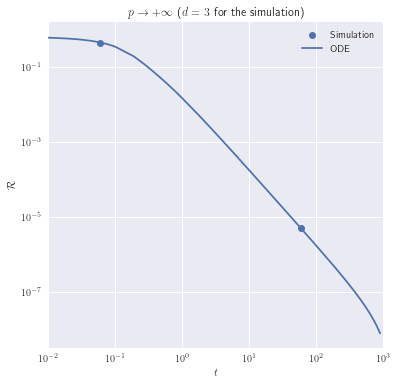

In [ ]:
from committee_learning.utilities import plot_style

import matplotlib.pyplot as plt

with plot_style():
  fig, ax = plt.subplots(figsize=(6,6))
  ax.set_title(f'$p\\to+\\infty$ ($d=\\num{{{d}}}$ for the simulation)')
  ax.set_xlim(1e-2,10**log_time)
  # ax.set_ylim(2e-1,1.)

  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$\mathcal{R}$')

  
  sim_plot = ax.plot(
    np.array(simr.steps)[::3]*(gamma/p/d),
    np.array(simr.risks[::3]),
    ls='',
    label=f'Simulation',
    marker='o'
  )
  
  ax.plot(oder.times, np.array(oder.risks), label=f'ODE', c = sim_plot[0].get_color())
    
  ax.legend()
  plt.show()

In [ ]:
if k == 1:
  from matplotlib import animation
  from IPython import display
  from mpl_toolkits.axes_grid1.inset_locator import inset_axes

  M = np.array(oder.Ms).reshape((len(oder.Ms),len(oder.Ms[0])))
  diagQ = M**2 + np.array(oder.Qorths)
  M = M / np.sqrt(oder.P[0][0]*diagQ)
  t = oder.times
  bins = int(np.sqrt(p))//2
  print(M.shape[0])
  with plot_style(style='classic'):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel(r'${M_{j1}}/{\sqrt{P_{11} Q_{jj} }}$') 
    ax.set_xlim(-1,1.)
    ax.set_ylim(0.,4.)
    risk_ax = inset_axes(ax, width='45%', height='45%', loc = 9)
    risk_ax.set_xscale('log')
    risk_ax.set_yscale('log')
    risk_ax.set_xlabel('$t$', labelpad= -18.)
    risk_ax.set_ylabel(r'$\mathcal{R}-\frac{\Delta}{2}$', labelpad= -27.)
    risk_ax.set_yticklabels([])
    risk_ax.set_xticklabels([])
    risk_ax.set_xlim(1e-3,10**log_time)
    risk_ax.set_ylim(1e-8,1.5)

    risk_plot = risk_ax.plot([], [])[0]
    _, _, bar_container = ax.hist([],bins, density=True, alpha=.5, range=(-1.,1.))

    def prepare_animation(bar_container):
      def animate(frame_number):
        risk_plot.set_data(oder.times[:frame_number], oder.risks[:frame_number])
        bs, _ = np.histogram(M[frame_number], bins=bins, density=True)
        for count, rect in zip(bs, bar_container.patches):
            rect.set_height(count)
        return *bar_container.patches, risk_plot
      return animate
    
    anim = animation.FuncAnimation(fig, prepare_animation(bar_container), frames=M.shape[0], interval=150, blit=True)

    # To save the animation as a gif
    writer = animation.PillowWriter(fps=15, bitrate=1800)
    anim.save('figures/histogram.gif', writer=writer)
    
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    


60


/Users/lucaarnaboldi/Desktop/DimensionlessDynamicsSGD/venv/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
